# SECTION 2 — TREAT
In this section we **modify** the dataset.

Goal: Turn the noisy SEE dataset into a stable, cleaned dataset that can be used for KPIs and simple models.

We assume the raw dataframe is called `df` and comes from `Global_Shipments_v3.csv`.

## 2.0 Create Before/After Copies
We keep an untouched copy (`df_before`) and create a working copy (`df_treat`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing the data

url =  "https://raw.githubusercontent.com/saikisri97/17_Hof_Lecture_Code_Pingo/refs/heads/main/Supply_Chain_Analytics/data/Global_Shipments.csv"
df = pd.read_csv(url)
df.head(5)

df_before = df.copy()
df_treat = df.copy()
df_treat.head()


,Shipment_ID,Week,Warehouse_ID,Store_ID,Carrier,Product_Category,Weight_kg,Delivery_Time_hrs,Fuel_Price_EUR_per_litre,Temperature_C,Promo_Flag,On_Time_Flag,Weekly_Sales_EUR,Notes
0,SH00000,2024-02-18,C,S07,C3,Frozen,19.06,29.3,1.67,2.7,0,1,64724.47,NaN
1,SH00001,2024-05-19,B,S05,C3,Grocery,10.35,30.4,1.61,2.5,0,1,61723.79,NaN
2,SH00002,2024-04-14,C,S07,C1,Clothing,14.93,34.7,1.63,NaN,1,1,54098.40,Partial delivery
3,SH00003,2024-03-17,B,S03,C3,Electronics,11.06,29.8,1.76,NaN,0,0,60609.65,Damaged carton
4,SH00004,2024-02-25,C,S12,C1,Grocery,3.41,27.3,1.69,-0.7,0,0,55689.16,NaN


## 2.1 Missingness Overview (Recap)
Quick recap of missing values **before** any treatment.

In [2]:
df_treat.isna().sum()


Shipment_ID                   0
Week                          0
Warehouse_ID                  0
Store_ID                      0
Carrier                       0
Product_Category              0
Weight_kg                    38
Delivery_Time_hrs            22
Fuel_Price_EUR_per_litre     50
Temperature_C               106
Promo_Flag                    0
On_Time_Flag                  0
Weekly_Sales_EUR              0
Notes                       611
dtype: int64

## 2.2 Helper Function: Missingness by Column
This function will help us see counts and percentages of missing values.

In [3]:
def missing_report(dataframe):
    miss_count = dataframe.isna().sum()
    miss_pct = (dataframe.isna().mean() * 100).round(2)
    report = pd.DataFrame({'Missing_Count': miss_count,
                          'Missing_Pct': miss_pct})
    return report.sort_values('Missing_Pct', ascending=False)

missing_report(df_treat)


,Missing_Count,Missing_Pct
Notes,611,61.1
Temperature_C,106,10.6
Fuel_Price_EUR_per_litre,50,5.0
Weight_kg,38,3.8
Delivery_Time_hrs,22,2.2
Shipment_ID,0,0.0
Week,0,0.0
Warehouse_ID,0,0.0
Store_ID,0,0.0
Carrier,0,0.0


## 2.3 Handling Missing Values — Non-Critical Field: `Notes`
`Notes` is free-text and does not block KPI calculations. We can safely fill missing entries with `'No issue'`.

In [4]:
df_treat['Notes'] = df_treat['Notes'].fillna('No issue')
missing_report(df_treat)


,Missing_Count,Missing_Pct
Temperature_C,106,10.6
Fuel_Price_EUR_per_litre,50,5.0
Weight_kg,38,3.8
Delivery_Time_hrs,22,2.2
Shipment_ID,0,0.0
Week,0,0.0
Warehouse_ID,0,0.0
Store_ID,0,0.0
Carrier,0,0.0
Product_Category,0,0.0


## 2.4 Handling Missing Values — Numeric Fields
We focus on numeric columns that impact KPIs:
- `Weight_kg`
- `Delivery_Time_hrs`
- `Fuel_Price_EUR_per_litre`
- `Weekly_Sales_EUR`
- `Temperature_C`

Strategy:
- For `Weight_kg`: impute median **per Product_Category** (MAR pattern).
- For `Delivery_Time_hrs`: fix negatives, then impute global median.
- For `Fuel_Price_EUR_per_litre`: impute global median.
- For `Weekly_Sales_EUR`: impute global median.
- For `Temperature_C`: impute median per Product_Category (cold-chain vs ambient).

### 2.4.1 Fix Impossible Negatives (Logical Cleaning Before Imputation)
Set negative `Delivery_Time_hrs` and non-positive `Weight_kg` to NaN so they are treated as missing.

In [5]:
# Set negative delivery times to NaN
df_treat.loc[df_treat['Delivery_Time_hrs'] < 0, 'Delivery_Time_hrs'] = np.nan

# Set zero or negative weights to NaN
df_treat.loc[df_treat['Weight_kg'] <= 0, 'Weight_kg'] = np.nan

missing_report(df_treat)


,Missing_Count,Missing_Pct
Temperature_C,106,10.6
Fuel_Price_EUR_per_litre,50,5.0
Weight_kg,38,3.8
Delivery_Time_hrs,22,2.2
Shipment_ID,0,0.0
Week,0,0.0
Warehouse_ID,0,0.0
Store_ID,0,0.0
Carrier,0,0.0
Product_Category,0,0.0


### 2.4.2 Impute `Weight_kg` by `Product_Category`
We assume missing weights follow a **MAR** pattern and depend on `Product_Category`.

In [6]:
df_treat['Weight_kg'] = df_treat.groupby('Product_Category')['Weight_kg']\
                             .transform(lambda s: s.fillna(s.median()))
missing_report(df_treat)


,Missing_Count,Missing_Pct
Temperature_C,106,10.6
Fuel_Price_EUR_per_litre,50,5.0
Delivery_Time_hrs,22,2.2
Shipment_ID,0,0.0
Week,0,0.0
Warehouse_ID,0,0.0
Store_ID,0,0.0
Carrier,0,0.0
Product_Category,0,0.0
Weight_kg,0,0.0


### 2.4.3 Impute `Delivery_Time_hrs` with Global Median
After removing impossible negatives, we impute remaining missing `Delivery_Time_hrs` values with the overall median.

In [7]:
delivery_median = df_treat['Delivery_Time_hrs'].median()
df_treat['Delivery_Time_hrs'] = df_treat['Delivery_Time_hrs'].fillna(delivery_median)
missing_report(df_treat)


,Missing_Count,Missing_Pct
Temperature_C,106,10.6
Fuel_Price_EUR_per_litre,50,5.0
Shipment_ID,0,0.0
Week,0,0.0
Warehouse_ID,0,0.0
Store_ID,0,0.0
Carrier,0,0.0
Product_Category,0,0.0
Weight_kg,0,0.0
Delivery_Time_hrs,0,0.0


### 2.4.4 Impute `Fuel_Price_EUR_per_litre` and `Weekly_Sales_EUR`
We use simple median imputation for these financial fields.

In [8]:
for col in ['Fuel_Price_EUR_per_litre', 'Weekly_Sales_EUR']:
    median_val = df_treat[col].median()
    df_treat[col] = df_treat[col].fillna(median_val)

missing_report(df_treat)


,Missing_Count,Missing_Pct
Temperature_C,106,10.6
Shipment_ID,0,0.0
Week,0,0.0
Warehouse_ID,0,0.0
Store_ID,0,0.0
Carrier,0,0.0
Product_Category,0,0.0
Weight_kg,0,0.0
Delivery_Time_hrs,0,0.0
Fuel_Price_EUR_per_litre,0,0.0


### 2.4.5 Impute `Temperature_C` by `Product_Category`
We assume different categories have different temperature profiles (cold-chain vs ambient).

In [9]:
df_treat['Temperature_C'] = df_treat.groupby('Product_Category')['Temperature_C']\
                                  .transform(lambda s: s.fillna(s.median()))
missing_report(df_treat)


,Missing_Count,Missing_Pct
Shipment_ID,0,0.0
Week,0,0.0
Warehouse_ID,0,0.0
Store_ID,0,0.0
Carrier,0,0.0
Product_Category,0,0.0
Weight_kg,0,0.0
Delivery_Time_hrs,0,0.0
Fuel_Price_EUR_per_litre,0,0.0
Temperature_C,0,0.0


## 2.5 Data Type Corrections
Make sure numeric, categorical, and flag columns have correct data types.

In [10]:
numeric_cols = ['Weight_kg', 'Delivery_Time_hrs', 'Fuel_Price_EUR_per_litre',
                'Weekly_Sales_EUR', 'Temperature_C']
for col in numeric_cols:
    df_treat[col] = pd.to_numeric(df_treat[col], errors='coerce')

# Flags as integers (allowing for potential missing before casting)
df_treat['Promo_Flag'] = pd.to_numeric(df_treat['Promo_Flag'], errors='coerce').astype('Int64')
df_treat['On_Time_Flag'] = pd.to_numeric(df_treat['On_Time_Flag'], errors='coerce').astype('Int64')

# Categorical columns
cat_cols = ['Shipment_ID', 'Warehouse_ID', 'Store_ID', 'Week',
            'Carrier', 'Product_Category']
for col in cat_cols:
    df_treat[col] = df_treat[col].astype('category')

df_treat.dtypes


Shipment_ID                 category
Week                        category
Warehouse_ID                category
Store_ID                    category
Carrier                     category
Product_Category            category
Weight_kg                    float64
Delivery_Time_hrs            float64
Fuel_Price_EUR_per_litre     float64
Temperature_C                float64
Promo_Flag                     Int64
On_Time_Flag                   Int64
Weekly_Sales_EUR             float64
Notes                         object
dtype: object

## 2.6 Outlier Treatment — `Delivery_Time_hrs`
We treat outliers in `Delivery_Time_hrs` using the IQR rule and **capping** (winsorizing) extreme values.
We only cap values that are far beyond the normal operating range.

In [11]:
q1 = df_treat['Delivery_Time_hrs'].quantile(0.25)
q3 = df_treat['Delivery_Time_hrs'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
lower_bound, upper_bound


(15.662499999999996, 39.7625)

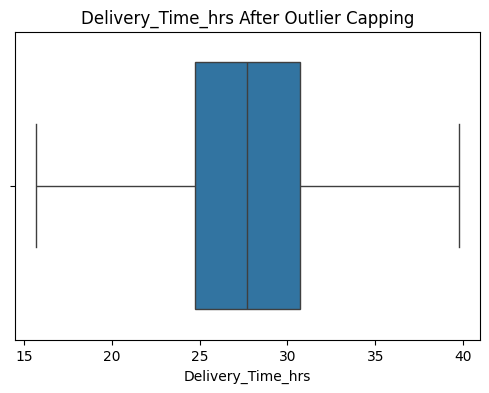

In [12]:
# Cap values outside [lower_bound, upper_bound]
df_treat['Delivery_Time_hrs'] = df_treat['Delivery_Time_hrs'].clip(lower=lower_bound, upper=upper_bound)

plt.figure(figsize=(6,4))
sns.boxplot(x=df_treat['Delivery_Time_hrs'])
plt.title('Delivery_Time_hrs After Outlier Capping')
plt.xlabel('Delivery_Time_hrs')
plt.show()


## 2.7 Quick Before/After Comparison
Compare missingness and distributions before and after TREAT.

In [13]:
print('Before TREAT:')
print(missing_report(df_before))
print('\nAfter TREAT:')
print(missing_report(df_treat))


Before TREAT:
                          Missing_Count  Missing_Pct
Notes                               611         61.1
Temperature_C                       106         10.6
Fuel_Price_EUR_per_litre             50          5.0
Weight_kg                            38          3.8
Delivery_Time_hrs                    22          2.2
Shipment_ID                           0          0.0
Week                                  0          0.0
Warehouse_ID                          0          0.0
Store_ID                              0          0.0
Carrier                               0          0.0
Product_Category                      0          0.0
Promo_Flag                            0          0.0
On_Time_Flag                          0          0.0
Weekly_Sales_EUR                      0          0.0

After TREAT:
                          Missing_Count  Missing_Pct
Shipment_ID                           0          0.0
Week                                  0          0.0
Warehouse_ID      

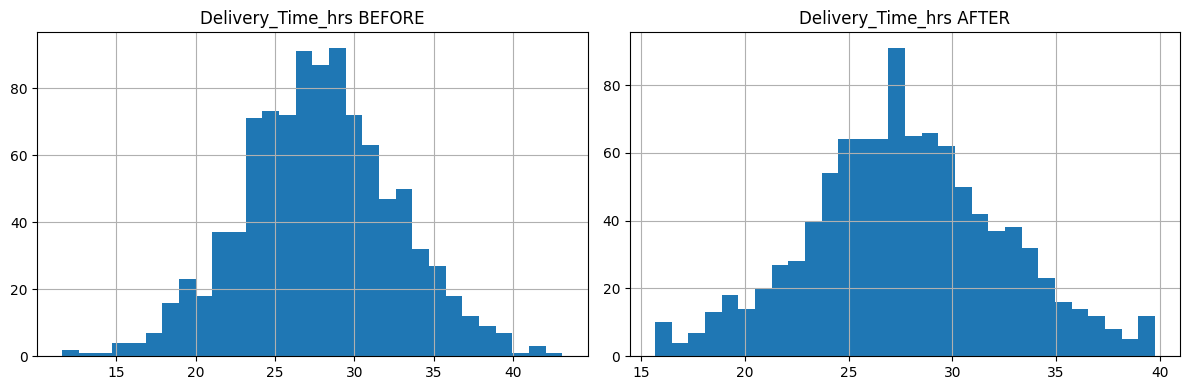

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df_before['Delivery_Time_hrs'].hist(bins=30, ax=axes[0])
axes[0].set_title('Delivery_Time_hrs BEFORE')
df_treat['Delivery_Time_hrs'].hist(bins=30, ax=axes[1])
axes[1].set_title('Delivery_Time_hrs AFTER')
plt.tight_layout()
plt.show()


## 2.8 Save Cleaned Dataset
Optionally, save the treated dataset for VERIFY and later modeling.

In [15]:
df_treat.to_csv('Global_Shipments_v3_TREATED.csv', index=False)
df_treat.head()


,Shipment_ID,Week,Warehouse_ID,Store_ID,Carrier,Product_Category,Weight_kg,Delivery_Time_hrs,Fuel_Price_EUR_per_litre,Temperature_C,Promo_Flag,On_Time_Flag,Weekly_Sales_EUR,Notes
0,SH00000,2024-02-18,C,S07,C3,Frozen,19.06,29.3,1.67,2.7,0,1,64724.47,No issue
1,SH00001,2024-05-19,B,S05,C3,Grocery,10.35,30.4,1.61,2.5,0,1,61723.79,No issue
2,SH00002,2024-04-14,C,S07,C1,Clothing,14.93,34.7,1.63,4.9,1,1,54098.40,Partial delivery
3,SH00003,2024-03-17,B,S03,C3,Electronics,11.06,29.8,1.76,5.1,0,0,60609.65,Damaged carton
4,SH00004,2024-02-25,C,S12,C1,Grocery,3.41,27.3,1.69,-0.7,0,0,55689.16,No issue
